Link to Colab Notebook: https://bit.ly/3OITZGK

# **Predicting News Popularity with Supervised Machine Learning**
**Contributors:** Achinthya Sreedhar, Neha Shastri, Chaitali Deshmukh, Aryan Sehgal

Team 2 Section B

## **Problem Statement**
The problem this project aims to solve is predicting the success of newly published news articles by forecasting their popularity based on various factors that influence user engagement. By examining features such as title length, category, and publication date, our goal is to develop a model that estimates the likelihood of an article achieving high engagement, quantified as the ratio of clicks to impressions. This model will help news platforms anticipate article success, allowing them to make more informed decisions about content selection, promotion strategies, and personalized recommendations, to maximize reader engagement.

## **Business Significance**
The stakeholders for this project include news platform operators, content strategists, and digital marketers who are directly responsible for curating and promoting news content. By leveraging the predictive capabilities of the model, these stakeholders can identify potential high-performing articles even before they are published, enabling more strategic decision-making. News platforms can prioritize articles with a higher likelihood of success for placement on their homepages, feature sections, or social media channels, optimizing visibility and reader interaction. Additionally, content teams can use the insights to refine future editorial strategies by understanding which factors, such as title length, category, or timing, will draw their audience.

## **Data Source**

**Microsoft News Dataset (MIND)**

https://msnews.github.io/index.html

behaviors.tsv:
- Contains click histories and impression logs of users.
- Used to analyze user interaction patterns and define the target variable, click percentage.

news.tsv:
- Contains information of news articles.
- Used to extract features such as title length and category for predictive modeling.

# **Data Dictionary**

**Field**                 | **Description**                                                                                      | **Data Type**   
--------------------------|------------------------------------------------------------------------------------------------------|-----------------  
**news_id**               | Unique identifier for the news article.                                                             | object          
**category**              | The category to which the article belongs.                                                          | object          
**sub_category**          | The subcategory within the main category of the article.                                            | object          
**title**                 | The title of the news article.                                                                      | object          
**title_length**          | The number of characters in the article's title.                                                    | int64           
**user_impression**       | The total number of impressions the article received.                                               | int64           
**user_click**            | The total number of user clicks on the article.                                                     | int64           
**active_duration_days**  | The total number of days during which the news article received impressions.                        | int64           
**weekend_indicator**     | Indicates whether or not the article was published on a weekend.                                    | int64           
**first_impression_date** | The date when the article received its first impression.                                             | datetime64      
**last_impression_date**  | The date when the article received its last impression.                                              | datetime64      
**click_percentage**      | Represents the percentage of user clicks relative to user impressions for each user.                | float64         
**click_percentage_flag** | A binary flag indicating whether the click_percentage is greater than zero.                         | category        
      


# **Data Preparation**

## **Data Import**

In [ ]:
#import statements
import pandas as pd
import numpy as np
import json
from datetime import datetime
from multiprocessing import Pool, cpu_count
from collections import defaultdict
import time

In [ ]:
train_news_dataset = pd.read_csv('MINDlarge_train/news.tsv', sep='\t', header=None)

In [ ]:
train_behaviors_dataset = pd.read_csv('MINDlarge_train/behaviors.tsv', sep='\t', header=None)

In [ ]:
valid_news_dataset = pd.read_csv('MINDlarge_dev/news.tsv', sep='\t', header=None)

In [ ]:
valid_behaviors_dataset = pd.read_csv('MINDlarge_dev/behaviors.tsv', sep='\t', header=None)

In [ ]:
test_news_dataset = pd.read_csv('MINDlarge_test/news.tsv', sep='\t', header=None)

In [ ]:
test_behaviors_dataset = pd.read_csv('MINDlarge_test/behaviors.tsv', sep='\t', header=None)

Loading all the required files into dataframes using pandas

In [ ]:
combined_news_dataset = pd.concat([train_news_dataset, valid_news_dataset, test_news_dataset])

In [ ]:
combined_behaviors_dataset = pd.concat([train_behaviors_dataset, valid_behaviors_dataset, test_behaviors_dataset])

Concatinating all the train, test, and validation news and behaviors datasets to create combinated news dataset and behaviors.

In [ ]:
print(combined_news_dataset.shape, combined_behaviors_dataset.shape)

(294509, 8) (4979946, 5)


In [ ]:
combined_news_dataset.to_parquet('combined_news_dataset.parquet',  index=False)
combined_behaviors_dataset.to_parquet('combined_behaviors_dataset.parquet',  index=False)

Saved it in parquet format because its good at reading large files.

## **Feature Engineering**

In [ ]:
data1 = pd.DataFrame()
data1 = combined_news_dataset.rename(columns={0: 'news_id', 1: 'category'})
data1['title_length'] = combined_news_dataset[3].str.len()
data1 = data1.drop(data1.columns[[2,3,4,5,6,7]], axis=1) # Dropping the first and third columns

Creating a dataframe called 'data' with only the required columns from the combined news dataset and choosing appropriate names

In [ ]:
columns = [
    'news_id',
    'first_impression_date',
    'last_impression_date',
    'user_impression',
    'user_click'
]

# Create an empty DataFrame with the specified columns
data2 = pd.DataFrame(columns=columns)

In [ ]:
start_time = time.time()

#Define the function to process each chunk with progress updates
def process_chunk(chunk, chunk_id):
    # Dictionary to store aggregated data for the chunk
    data = defaultdict(lambda: {'user_impression': 0, 'user_click': 0, 'first_impression_date': None, 'last_impression_date': None})
    row_count = 0  # Initialize row counter for progress updates

    for index, row in chunk.iterrows():
        row_count += 1
        if row_count % 10000 == 0:  # Update every 10,000 rows
            pass
            #print(f"Chunk {chunk_id}: Processed {row_count} rows\n")

        # Parse impression date
        impression_date = pd.to_datetime(row[2]).date()

        # Process each news item in the impressions
        news_list = row[4].split(' ')

        for i in news_list:
            clicked = 1 if i.endswith("-1") else 0
            news = i[:-2] if i.endswith(("-1", "-0")) else i #extracting the news ID from the list.

            if news not in data:
                # Initialize entry if not present
                data[news]['first_impression_date'] = impression_date
                data[news]['last_impression_date'] = impression_date

            # Update counts
            data[news]['user_impression'] += 1
            data[news]['user_click'] += clicked

            # Update impression dates
            if impression_date < data[news]['first_impression_date']:
                data[news]['first_impression_date'] = impression_date
            elif impression_date > data[news]['last_impression_date']:
                data[news]['last_impression_date'] = impression_date

    # Convert dictionary to DataFrame for the chunk
    chunk_result = pd.DataFrame([
        {'news_id': news,
         'first_impression_date': values['first_impression_date'],
         'last_impression_date': values['last_impression_date'],
         'user_impression': values['user_impression'],
         'user_click': values['user_click']}
        for news, values in data.items()
    ])

    #print(f"Chunk {chunk_id}: Completed processing with total {row_count} rows\n")
    return chunk_result

# Function to process the entire dataset in parallel with progress updates
def parallel_process_behaviors(dataset, num_chunks):
    # Split dataset into chunks
    chunk_size = len(dataset) // num_chunks
    chunks = [dataset.iloc[i:i + chunk_size] for i in range(0, len(dataset), chunk_size)]

    # Use multiprocessing Pool to process each chunk in parallel
    with Pool(processes=cpu_count()) as pool:
        # Pass the chunk ID along with each chunk for progress tracking
        results = pool.starmap(process_chunk, [(chunk, chunk_id) for chunk_id, chunk in enumerate(chunks)])

    # Combine all chunk results into a single DataFrame
    combined_result = pd.concat(results, ignore_index=True)

    # Aggregate data by 'news_id' (since each chunk processed independently)
    final_result = combined_result.groupby('news_id').agg({
        'first_impression_date': 'min',
        'last_impression_date': 'max',
        'user_impression': 'sum',
        'user_click': 'sum'
    }).reset_index()

    return final_result

num_chunks = 64
data2 = parallel_process_behaviors(combined_behaviors_dataset, num_chunks)

end_time = time.time()

elapsed_time = end_time - start_time

Processing the large dataset of user interactions with news articles by splitting it into chunks for parallel processing. Each chunk calculates aggregated metrics like total impressions, clicks, and the first and last impression dates for each news ID, and the results are merged and aggregated for the final output

In [ ]:
data2['first_impression_date'] = pd.to_datetime(data2['first_impression_date'])
data2['last_impression_date'] = pd.to_datetime(data2['last_impression_date'])
data2['active_duration_days'] = data2['last_impression_date'] - data2['first_impression_date']
data2['active_duration_days'] = data2['active_duration_days'].apply(lambda x: x.days) + 1
data2['weekend_indicator'] = data2['first_impression_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
data2['click_percentage']= data2['user_click']/data2['user_impression']*100

Transforming the dataset by formatting date features and deriving new features such as active duration in days, weekend indicator, and click percentage to obtain the data for machine learning models

In [ ]:
data2 = data2.drop(['last_impression_date', 'first_impression_date', 'user_click', 'user_impression'], axis=1)
data2.info()

Dropping columns that have already been transformed or are no longer needed for further analysis

## **Data Cleaning**

In [ ]:
data1[data1.duplicated(subset=['news_id'])].head(3)

In [ ]:
data1.drop_duplicates(subset=['news_id'], keep='first', inplace=True)

Removing duplicate rows based on the news_id column, keeping only the first occurrence of each news_id

In [ ]:
data2[data2.duplicated()].head(3) #no duplicates

No more duplicate value exists

In [ ]:
data = pd.merge(data1, data2, on="news_id", how="inner")

Performing an inner join between data1 and data2 on the news_id column to create the final dataframe data

In [ ]:
data.info()

In [ ]:
data.to_parquet('final_dataset.parquet')

Saving the dataset to a Parquet file

# **Exploratory Data Analysis**

In [ ]:
import pandas as pd
data = pd.read_parquet('final_dataset.parquet')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54581 entries, 0 to 54580
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   news_id               54581 non-null  object 
 1   category              54581 non-null  object 
 2   title_length          54581 non-null  int64  
 3   user_impression       54581 non-null  int64  
 4   user_click            54581 non-null  int64  
 5   active_duration_days  54581 non-null  int64  
 6   weekend_indicator     54581 non-null  int64  
 7   click_percentage      54581 non-null  float64
dtypes: float64(1), int64(5), object(2)
memory usage: 3.3+ MB


Ensuring that all the columns are in the required format

In [ ]:
numerical_columns = ['title_length','user_impression','user_click','active_duration_days','click_percentage']
data[numerical_columns].describe()

,title_length,user_impression,user_click,active_duration_days,click_percentage
count,54581.000000,54581.000000,54581.000000,54581.000000,54581.000000
mean,65.929060,3494.035140,72.525256,2.380242,2.159126
std,20.690838,15570.473028,810.027834,2.533290,5.599133
min,9.000000,1.000000,0.000000,1.000000,0.000000
25%,53.000000,16.000000,0.000000,1.000000,0.000000
50%,64.000000,59.000000,0.000000,2.000000,0.000000
75%,78.000000,249.000000,2.000000,2.000000,2.195420
max,1601.000000,381470.000000,60638.000000,14.000000,100.000000


The describe method reveals significant skewness in click_percentage, with both the 25th and 50th percentiles at 0, indicating most articles have low engagement and this skewness must be visualised further.Features like user_impression and user_click show extreme variability, with a few outliers driving the maximum values. active_duration_days is short for most articles, while title_length is relatively consistent but has rare outliers.

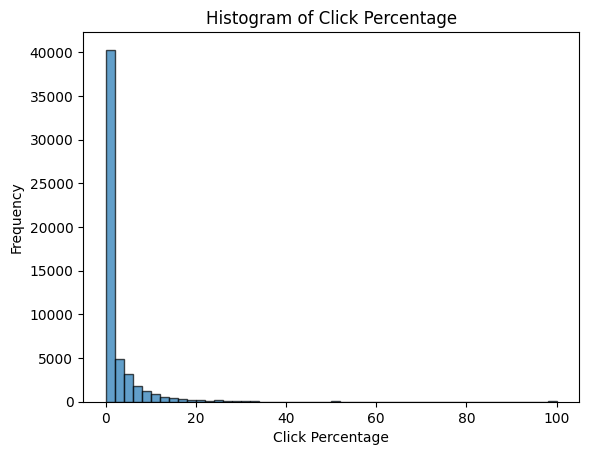

In [ ]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(data['click_percentage'], bins=50, edgecolor='black', alpha=0.7)

# Adding labels and title
plt.title('Histogram of Click Percentage')
plt.xlabel('Click Percentage')
plt.ylabel('Frequency')

# Display the plot
plt.show()

As we can see, most of the click percentage values are 0, indicating that the dataset is highly imbalanced and positively skewed. To address this, we will first run a classification model to predict whether a user clicks on an article or not. For articles that are clicked on, we will then use a regression model to predict the click percentage. Finally, we will combine the results from both the classification and regression models to achieve the most accurate predictions.

In [ ]:
data['click_percentage_flag'] = data['click_percentage'].apply(lambda x: 1 if x > 0 else 0)
data["click_percentage_flag"] = data["click_percentage_flag"].astype('category')

Creating a click percentage flag indicating whether a user clicked on the article or not and changing its type to ensure its categorical

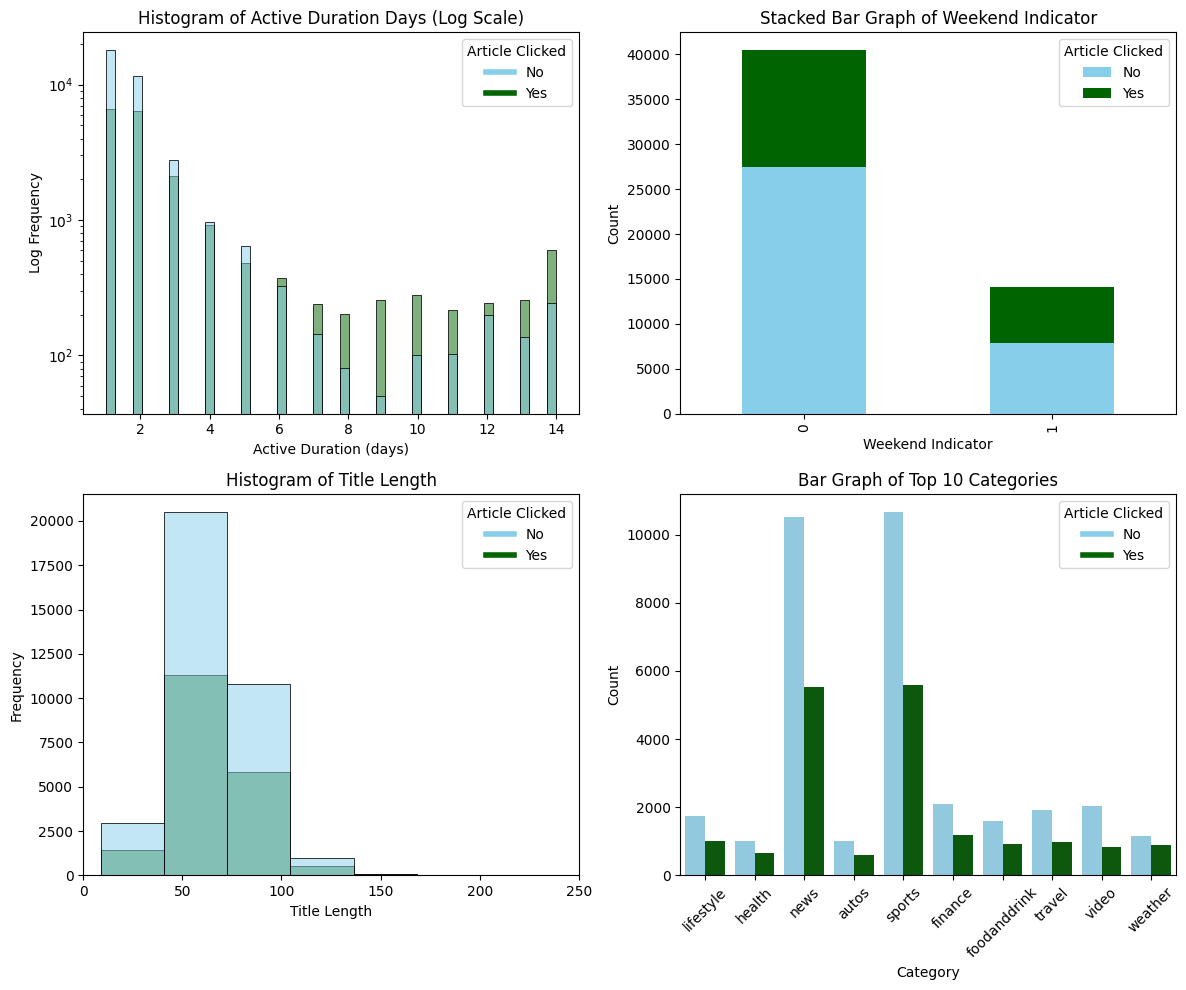

In [ ]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Define a consistent color mapping
color_mapping = {0: 'skyblue', 1: 'darkgreen'}  # No = skyblue, Yes = darkgreen
legend_labels = ['No', 'Yes']

# Apply a logarithmic scale to the Y-axis
sns.histplot(
    data=data,
    x='active_duration_days',
    hue='click_percentage_flag',
    bins=50,
    ax=axes[0, 0],
    palette=color_mapping
)
axes[0, 0].set_yscale('log')  # Set log scale for Y-axis
axes[0, 0].set_title('Histogram of Active Duration Days (Log Scale)')
axes[0, 0].set_xlabel('Active Duration (days)')
axes[0, 0].set_ylabel('Log Frequency')

# Manually add legend with correct labels and colors
custom_handles = [plt.Line2D([0], [0], color=color_mapping[key], lw=4) for key in color_mapping]
axes[0, 0].legend(custom_handles, legend_labels, title='Article Clicked', loc='upper right')

# Stacked bar chart for `weekend_indicator`
weekend_data = data.groupby(['weekend_indicator', 'click_percentage_flag']).size().unstack(fill_value=0)

weekend_data.plot(
    kind='bar',
    stacked=True,
    color=[color_mapping[0], color_mapping[1]],
    ax=axes[0, 1]
)
axes[0, 1].set_title('Stacked Bar Graph of Weekend Indicator')
axes[0, 1].set_xlabel('Weekend Indicator')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(legend_labels, title='Article Clicked', loc='upper right')

# Histogram for `title_length` with consistent colors
sns.histplot(
    data=data,
    x='title_length',
    hue='click_percentage_flag',
    bins=50,
    ax=axes[1, 0],
    palette=color_mapping,
    multiple="layer"
)
axes[1, 0].set_title('Histogram of Title Length')
axes[1, 0].set_xlabel('Title Length')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, 250)

# Manually add legend with correct labels and colors
axes[1, 0].legend(custom_handles, legend_labels, title='Article Clicked', loc='upper right')

# Bar graph for `category` with consistent colors
top_10_categories = data['category'].value_counts().head(10).index
filtered_data = data[data['category'].isin(top_10_categories)]

sns.countplot(
    data=filtered_data,
    x='category',
    hue='click_percentage_flag',
    ax=axes[1, 1],
    palette=color_mapping
)
axes[1, 1].set_title('Bar Graph of Top 10 Categories')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Manually add legend with correct labels and colors
axes[1, 1].legend(custom_handles, legend_labels, title='Article Clicked', loc='upper right')

plt.tight_layout()
plt.show()

Using these graphs, we can interpret that articles tend to be clicked more as the number of active duration in days increases. Also, most articles are published on the weekdays. The most popular categories to be published and clicked are those in news and sports, likely due to their broad appeal and large fan bases, as well as the continuous demand for real-time updates and coverage in these topics.

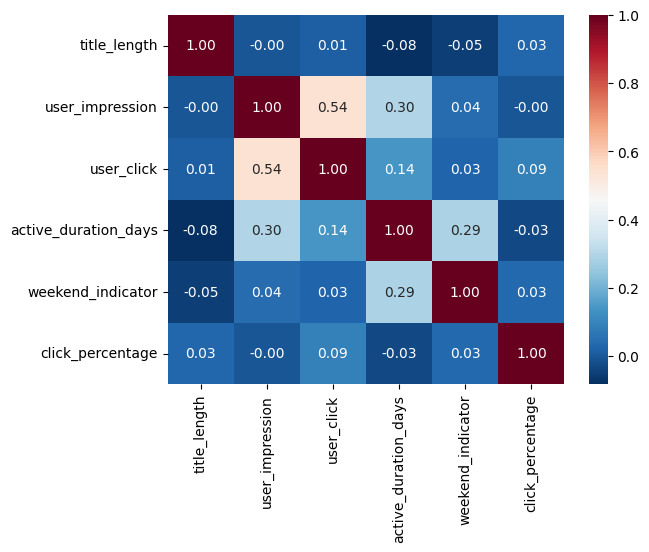

In [ ]:
import seaborn as sns

corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r');

The heatmap indicates a low correlation between click percentage and all other features whereas there is  moderate correlation between user impression and user click (0.54) indicates that articles displayed more frequently in user feeds are somewhat more likely to receive clicks

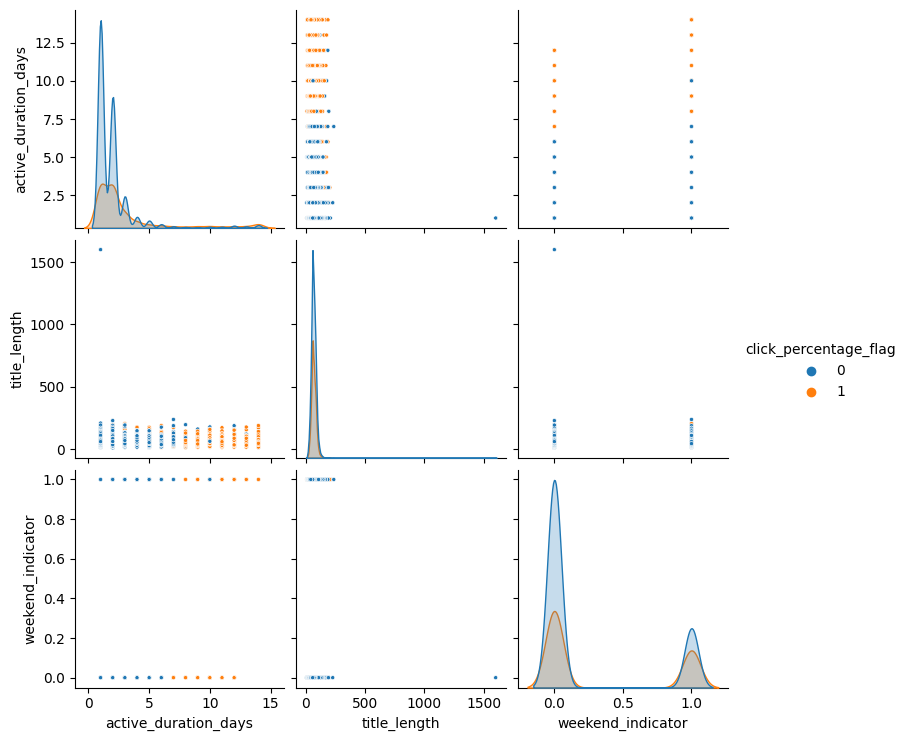

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)

attributes = [
    'active_duration_days',
    'title_length',
    'weekend_indicator',
    'click_percentage_flag'
]
sns.pairplot(data[attributes],hue='click_percentage_flag',  markers='.')
plt.show()

The pairplot shows that most articles have short active durations and relatively low title lengths. Additionally, the weekend indicator is dominated by non weekend impressions

# **Data Preprocessing**

In [ ]:
import pandas as pd
data = pd.read_parquet('final_dataset.parquet')
data['click_percentage_flag'] = data['click_percentage'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split

X = data.drop(['news_id','click_percentage', 'click_percentage_flag','user_impression','user_click'], axis=1)
y = data['click_percentage'].copy() # in case we modify values in y and don't want to affect original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Splitting the data into training and testing sets, with 75% of the records allocated to the training set and 25% to the test set

In [ ]:
#extract numerical columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

#extract categorical colums
categorical_columns = X_train.select_dtypes(include=['object']).columns

In [ ]:
#preprocessing pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler


cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", feature_name_combiner=lambda feature, category: f"{feature}={category}" )
  )

default_num_pipeline = make_pipeline(IterativeImputer(),
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, categorical_columns),
    ("num", default_num_pipeline, numerical_columns)
  ])

preprocessing

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(feature_name_combiner=<function <lambda> at 0x7f9b5642eb90>,
                                                                handle_unknown='ignore'))]),
                                 Index(['category'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('iterativeimputer',
                                                  IterativeImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['title_length', 'active_duration_days', 'weekend_indicator'], dtype='object'))])

Creating a preprocessing pipeline that applies one-hot encoding and imputes missing values. For numerical features, an iterative imputer is used, while for categorical features, the most frequent strategy is applied for imputation

In [ ]:
preprocessing.fit(X_train)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(feature_name_combiner=<function <lambda> at 0x7fe7b2712c20>,
                                                                handle_unknown='ignore'))]),
                                 Index(['category'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('iterativeimputer',
                                                  IterativeImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['title_length', 'active_duration_days', 'weekend_indicator'], dtype='object'))])

Fitting the preprocessing pipeline to the X_train

In [ ]:
preprocessing.get_feature_names_out()
#get number of features
len(preprocessing.get_feature_names_out())

18

After preprocessing, the dataset consists of 18 features in total.

We will first run a classification model to predict whether a user clicks on an article or not. For articles that are clicked on, we will then use a regression model to predict the click percentage. Finally, we will combine the results from both the classification and regression models to achieve the most accurate predictions.

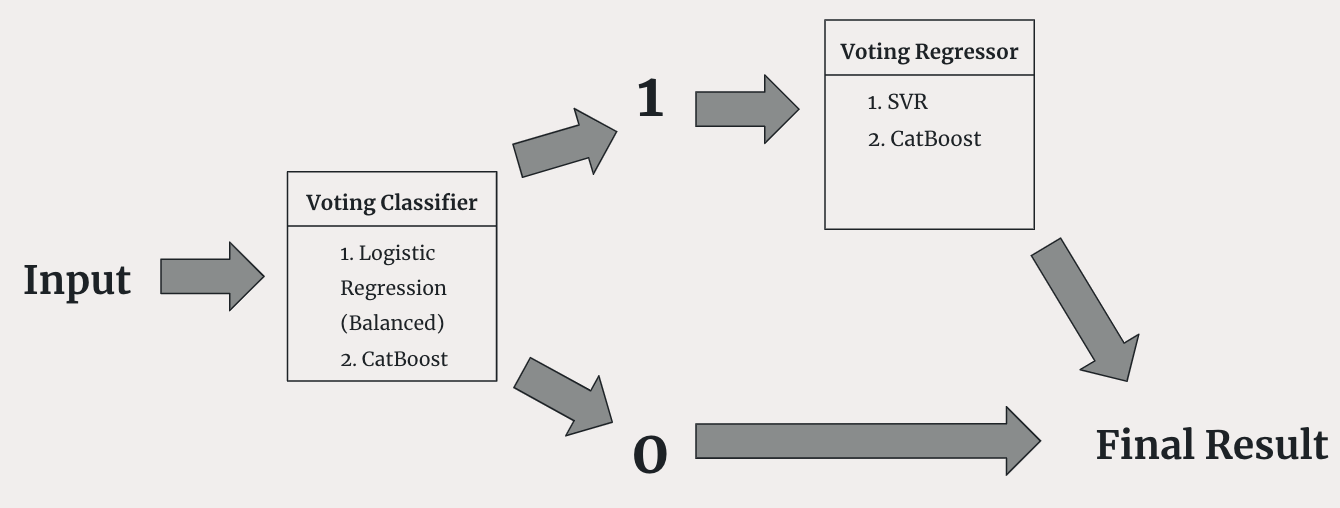

In [ ]:
from IPython.display import Image
Image("flowchart.png")

# **Classification Model**

## **Cost Function**
| Cost matrix    | **Predicted -** | **Predicted +** |
|----------------|-----------------|-----------------|
| **Actual -**   | 5               | -10               |
| **Actual +**   | -8               | 16               |

In [ ]:
from sklearn.metrics import make_scorer, confusion_matrix

def custom_gain(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tp_gain = cm[1, 1] * 16
    tn_gain = cm[0, 0] * 5
    fp_cost = cm[0, 1] * -10
    fn_cost = cm[1, 0] * -8
    return tp_gain + tn_gain + fp_cost + fn_cost

# Wrap in a scorer object
cost_scorer = make_scorer(custom_gain, greater_is_better=True)

This custom cost function calculates the net gain or loss based on the confusion matrix for a classification problem of whether a user clicked on an article or not. It assigns a gain of 16 for true positives (correctly predicted clicks) and 5 for true negatives (correctly predicted non-clicks), while penalizing false positives (incorrectly predicted clicks) with a cost of -10 and false negatives (missed clicks) with a cost of -8. The overall score represents the total gain, encouraging models to prioritize correct predictions while accounting for the cost of misclassifications.

## **Model Selection**


In [ ]:
y_train_classifier = y_train.apply(lambda x: 1 if x > 0 else 0)
y_test_classifier = y_test.apply(lambda x: 1 if x > 0 else 0)

Creating y_train_classifier because classification model cant use y_train directly hence we need to create a flag

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# Custom cost function (assumes you already defined `custom_gain` earlier)
cost_scorer = make_scorer(custom_gain, greater_is_better=True)

# Custom eval function for XGBoost
def custom_eval_metric(y_true, y_pred):
    return 'custom_gain', custom_gain(y_true, y_pred)

# Define classifiers
classifiers = {
    'Null Model (Majority Class)': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': make_pipeline(preprocessing, LogisticRegression(random_state=42, max_iter=1000)),
    'Logistic Regression (Balanced)': make_pipeline(preprocessing, LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')),

    'Ridge Classifier': make_pipeline(preprocessing, RidgeClassifier(random_state=42)),

    'SGD Classifier': make_pipeline(preprocessing, SGDClassifier(random_state=42)),
    'SGD Classifier (Balanced)': make_pipeline(preprocessing, SGDClassifier(random_state=42, class_weight='balanced')),

    'Decision Tree Classifier': make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42)),
    'Decision Tree Classifier (Balanced)': make_pipeline(preprocessing, DecisionTreeClassifier(random_state=42, class_weight='balanced')),

    'Random Forest Classifier': make_pipeline(preprocessing, RandomForestClassifier(random_state=42)),
    'Random Forest Classifier (Balanced)': make_pipeline(preprocessing, RandomForestClassifier(random_state=42, class_weight='balanced')),

    'Gradient Boosting Classifier': make_pipeline(preprocessing, GradientBoostingClassifier(random_state=42)),

    'XGBoost': make_pipeline(preprocessing, XGBClassifier(random_state=42, eval_metric=custom_eval_metric)),
    'XGBoost (Balanced)': make_pipeline(preprocessing, XGBClassifier(random_state=42, eval_metric=custom_eval_metric, scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))),

    'CatBoost': make_pipeline(preprocessing, CatBoostClassifier(random_state=42, verbose=0)),
    'CatBoost (Balanced)': make_pipeline(preprocessing, CatBoostClassifier(random_state=42, class_weights=[len(y_train[y_train == 0]), len(y_train[y_train == 1])], verbose=0))
}

# Initialize a list to store the results
results = []

# Iterate over classifiers
for name, clf in classifiers.items():
    print(f"Evaluating: {name}")

    # Perform cross-validation using the custom cost function
    scores = cross_val_score(clf, X_train, y_train_classifier, cv=5, scoring=cost_scorer)

    # Append the mean score and standard deviation
    results.append({
        'Model': name,
        'Mean Custom Gain': round(scores.mean(), 4),
        'Std Dev': round(scores.std(), 4)
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Set 'Model' as the index
results_df.set_index('Model', inplace=True)

# Display the results
print("\nModel Performance Comparison (Custom Gain Scorer):")
print(results_df)

Evaluating: Null Model (Majority Class)
Evaluating: Logistic Regression
Evaluating: Logistic Regression (Balanced)
Evaluating: Ridge Classifier
Evaluating: SGD Classifier
Evaluating: SGD Classifier (Balanced)
Evaluating: Decision Tree Classifier
Evaluating: Decision Tree Classifier (Balanced)
Evaluating: Random Forest Classifier
Evaluating: Random Forest Classifier (Balanced)
Evaluating: Gradient Boosting Classifier
Evaluating: XGBoost
Evaluating: XGBoost (Balanced)
Evaluating: CatBoost
Evaluating: CatBoost (Balanced)

Model Performance Comparison (Custom Gain Scorer):
                                     Mean Custom Gain   Std Dev
Model                                                          
Null Model (Majority Class)                    3710.8    6.3687
Logistic Regression                           10283.2  507.3434
Logistic Regression (Balanced)                14309.8  622.1345
Ridge Classifier                              10071.4  495.6429
SGD Classifier                          

Most models outperform the null model, which predicts that articles will not be clicked. The top three models are Logistic Regression (Balanced), CatBoost, and XGBoost. While some balanced models, like XGBoost (Balanced), perform poorly, the best-performing model is balanced, highlighting the importance of addressing class imbalances to achieve optimal performance.

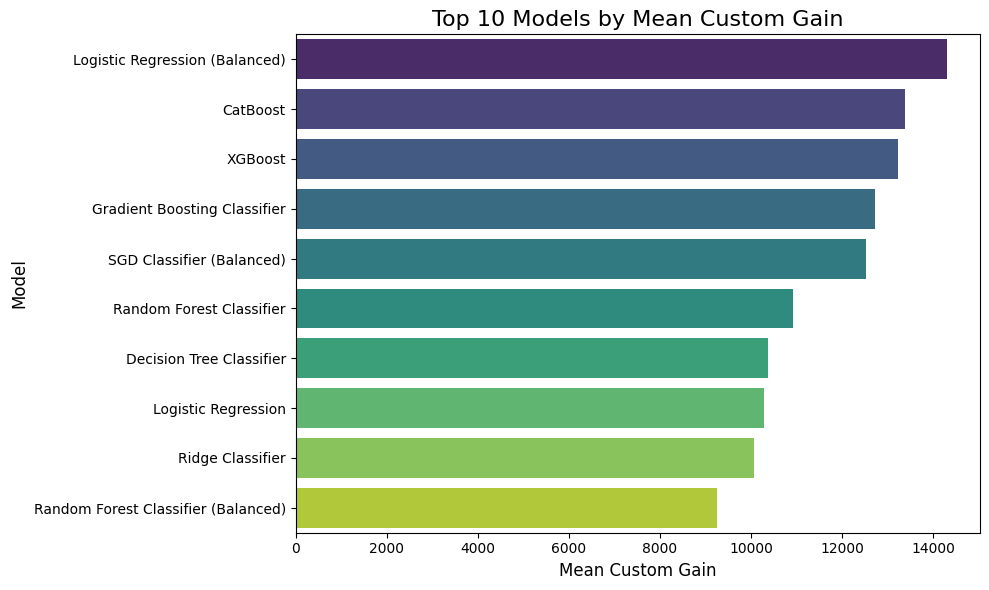

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'Mean Custom Gain' in descending order
top_10_models = results_df.sort_values(by='Mean Custom Gain', ascending=False).head(10)

# Plot the top 10 models using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_models['Mean Custom Gain'],
    y=top_10_models.index,
    palette='viridis'
)

# Add labels and title
plt.title('Top 10 Models by Mean Custom Gain', fontsize=16)
plt.xlabel('Mean Custom Gain', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Here, we have visualized the results using a bar plot to better convey the outcomes obtained from the analysis

## **Fine-Tuning the Top Three Models**

We selected the top three classification models to implement a voting ensemble method, ensuring there will always be a majority vote for robust and consistent predictions

**Logistic Regression Balanced**

In [ ]:
#make pipeline
logreg_clf = make_pipeline(preprocessing,
                           LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'
))

logreg_clf.fit(X_train, y_train_classifier)
y_pred = logreg_clf.predict(X_test)
test_score = custom_gain(y_test_classifier, y_pred)
print(f"Untuned Balanced Logistic Regression Test Score (Custom Gain): {test_score:.4f}")

Untuned Balanced Logistic Regression Test Score (Custom Gain): 23672.0000


The custom gain obtained here is before performing any hyperaparamter tuning

In [ ]:
# parameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint

# Assume `custom_gain` is already defined
cost_scorer = make_scorer(custom_gain, greater_is_better=True)

# Create a pipeline combining preprocessing and LogisticRegression
logreg_pipeline = make_pipeline(
    preprocessing,
    LogisticRegression(
        random_state=42,
        solver='liblinear',  # Use 'liblinear' solver for L1 or L2 regularization
        class_weight='balanced',
        penalty = 'l2'# Handles class imbalance
    )
)

# Define the parameter grid for Logistic Regression with random ranges
param_grid = {
    'logisticregression__C': uniform(0.1, 10),  # Randomly sample regularization strength between 0.1 and 10
    'logisticregression__max_iter': randint(100, 1000),  # Randomly sample number of iterations
    'logisticregression__tol': uniform(1e-5, 1e-4)  # Randomly sample tolerance for stopping criteria
}

# Perform hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=logreg_pipeline,
    param_distributions=param_grid,
    n_iter=100,  # Number of iterations to try different combinations
    scoring=cost_scorer,  # Use the custom cost function for scoring
    random_state=42,
    n_jobs=-1,  # Use all available CPUs to parallelize the search
    cv=5,  # 5-fold cross-validation
    verbose=1  # Set verbosity to 1 to see progress
)

# Fit the random search on the training data
random_search.fit(X_train, y_train_classifier)

# Output the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'logisticregression__C': 3.845401188473625, 'logisticregression__max_iter': 960, 'logisticregression__tol': 2.8343478986616378e-05}
Best Score: 14326.0


The random search process involved fitting 5 folds for each of 100 parameter combinations, totaling 500 fits. The best parameters identified for the Logistic Regression model are C=3.8454, max_iter=960, and tol=2.834e-05, achieving the highest custom gain score of 14,326.0. This highlights the optimal hyperparameters for maximizing the model's performance

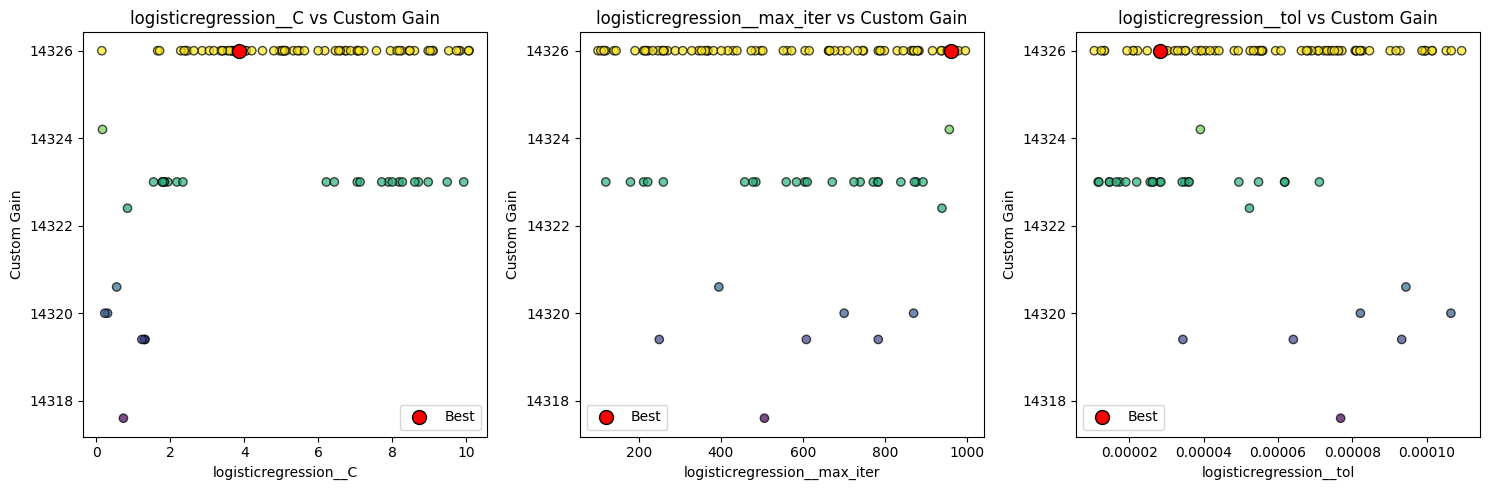

In [ ]:
# plotting parameters
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume the RandomizedSearchCV has already been fitted with the following:
# random_search.fit(X_train, y_train_classifier)

# Extract hyperparameters and custom gain scores from the RandomizedSearchCV results
results = random_search.cv_results_

# Extracting the hyperparameters and the corresponding mean test scores (custom gain scores)
hyperparameters = results['params']
mean_test_scores = results['mean_test_score']

# Convert the hyperparameters into a DataFrame for easy visualization
params_df = pd.DataFrame(hyperparameters)

# Add the mean test scores (custom gain) to the DataFrame
params_df['custom_gain'] = mean_test_scores

# Find the index of the best performing result
best_idx = params_df['custom_gain'].idxmax()
best_params = params_df.iloc[best_idx]
best_custom_gain = best_params['custom_gain']

# Now we can plot the hyperparameters against the custom gain scores.
# Here I will create a scatter plot for each hyperparameter individually.

fig, axes = plt.subplots(1, len(param_grid), figsize=(15, 5))  # One plot for each hyperparameter

# Iterate over each parameter and plot
for i, (param, ax) in enumerate(zip(param_grid.keys(), axes)):
    # Extract the specific hyperparameter and its custom gain values
    ax.scatter(params_df[param], params_df['custom_gain'], c=params_df['custom_gain'], cmap='viridis', edgecolors='k', alpha=0.7)

    # Highlight the best performing point with a red marker
    ax.scatter(best_params[param], best_custom_gain, color='red', s=100, label='Best', edgecolors='black')

    ax.set_xlabel(param)
    ax.set_ylabel('Custom Gain')
    ax.set_title(f'{param} vs Custom Gain')
    ax.legend()

plt.tight_layout()
plt.show()

This visualization plots the hyperparameters against their corresponding custom gain scores from the RandomizedSearchCV results. Each scatter plot represents the relationship between a specific hyperparameter and the model's custom gain score, helping to identify trends and the impact of each hyperparameter on performance. The best-performing hyperparameter combination is highlighted with a red marker, showcasing its optimal values for maximizing custom gain. This analysis aids in understanding the influence of hyperparameters on model performance.

In [ ]:
logreg_clf = make_pipeline(preprocessing,
                           LogisticRegression(
    random_state=42,
    max_iter=960,
    C=3.845401188473625,
    penalty='l2',
    tol=2.8343478986616378e-05,
    class_weight='balanced',
    solver='liblinear'
))

logreg_clf.fit(X_train, y_train_classifier)
y_pred = logreg_clf.predict(X_test)
test_score = custom_gain(y_test_classifier, y_pred)
print(f"Tuned Balanced Logistic Regression Test Score (Custom Gain): {test_score:.4f}")

Tuned Balanced Logistic Regression Test Score (Custom Gain): 23708.0000


After tuning, the Balanced Logistic Regression model achieved a slightly improved test score of 23,708.0 (custom gain), compared to the pre-tuning score of 23,672.0. This marginal increase indicates that hyperparameter optimization has fine-tuned the model's performance, enhancing its ability to balance gains and costs effectively.

**CatBoost**

In [ ]:
from catboost import CatBoostClassifier

# Initialize the CatBoostClassifier pipeline
catboost_clf = make_pipeline(preprocessing, CatBoostClassifier(  # Equivalent to binary:logistic for CatBoost
    random_state=42,
    verbose=0  # Suppress training output
))

# Fit the model
catboost_clf.fit(X_train, y_train_classifier)

# Make predictions
y_pred = catboost_clf.predict(X_test)

# Evaluate using the custom gain function
test_score = custom_gain(y_test_classifier, y_pred)
print(f"Untuned Test Score (Custom Gain) for CatBoostClassifier: {test_score:.4f}")

Untuned Test Score (Custom Gain) for CatBoostClassifier: 21473.0000


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform

# Assume `custom_gain` is already defined
cost_scorer = make_scorer(custom_gain, greater_is_better=True)

# Create a pipeline combining preprocessing and CatBoostClassifier
catboost_pipeline = make_pipeline(
    preprocessing,
    CatBoostClassifier(
        random_state=12,
        verbose=0  # Suppress training output
    )
)

# Define the parameter grid for CatBoostClassifier with random ranges
param_grid = { # Tree depth
    'catboostclassifier__l2_leaf_reg': uniform(1, 10)
}

# Perform hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of iterations to try different combinations
    scoring=cost_scorer,  # Use the custom cost function for scoring
    random_state=62,
    n_jobs=-1,
    cv=3,  # 5-fold cross-validation
    verbose=1  # Set verbosity to 1 to see progress
)

# Fit the random search on the training data
random_search.fit(X_train, y_train_classifier)

# Output the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'catboostclassifier__l2_leaf_reg': 7.314153737307647}
Best Score: 22449.666666666668


The random search process involved fitting 3 folds for each of 10 parameter combinations, totaling 30 fits. The best parameter identified for the CatBoost Classifier model is l2_leaf_reg=7.3142, achieving the highest custom gain score of 22,449.67. This highlights the optimal hyperparameter for maximizing the model's performance

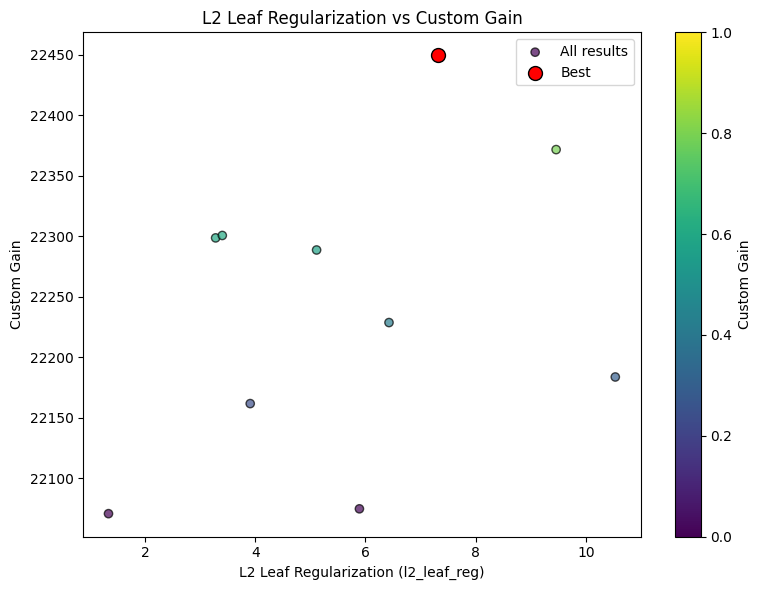

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume the RandomizedSearchCV for CatBoost has already been fitted:
# random_search.fit(X_train, y_train_classifier)

# Extract hyperparameters and custom gain scores from the RandomizedSearchCV results
results = random_search.cv_results_

# Extract the single hyperparameter and the corresponding mean test scores (custom gain scores)
params = [param['catboostclassifier__l2_leaf_reg'] for param in results['params']]
mean_test_scores = results['mean_test_score']

# Create a DataFrame for visualization
params_df = pd.DataFrame({
    'l2_leaf_reg': params,
    'custom_gain': mean_test_scores
})

# Find the best performing result
best_idx = params_df['custom_gain'].idxmax()
best_l2_leaf_reg = params_df.loc[best_idx, 'l2_leaf_reg']
best_custom_gain = params_df.loc[best_idx, 'custom_gain']

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(params_df['l2_leaf_reg'], params_df['custom_gain'],
            c=params_df['custom_gain'], cmap='viridis', edgecolors='k', alpha=0.7, label='All results')

# Highlight the best result
plt.scatter(best_l2_leaf_reg, best_custom_gain, color='red', s=100, edgecolors='black', label='Best')

plt.xlabel('L2 Leaf Regularization (l2_leaf_reg)')
plt.ylabel('Custom Gain')
plt.title('L2 Leaf Regularization vs Custom Gain')
plt.legend()
plt.colorbar(label='Custom Gain')
plt.tight_layout()
plt.show()

This visualization depicts the relationship between the l2_leaf_reg hyperparameter and the custom gain score for the CatBoost Classifier, obtained from the RandomizedSearchCV process. The best result, achieved with l2_leaf_reg=7.3142, yielded the highest custom gain score of 22,449.67, as highlighted by the red marker. This plot helps illustrate how varying the regularization parameter impacts the model's performance and identifies the optimal value for maximizing gains.

In [ ]:
from catboost import CatBoostClassifier

# Create the CatBoostClassifier pipeline with tuned parameters
catboost_clf = make_pipeline(preprocessing, CatBoostClassifier( # Equivalent to binary:logistic for CatBoost
    random_state=42,
    max_depth = 7,
    l2_leaf_reg= 7.314153737307647,
    verbose=0  # Suppress training output
))

# Fit the CatBoost pipeline on the training data
catboost_clf.fit(X_train, y_train_classifier)

# Predict on the test set
y_pred = catboost_clf.predict(X_test)

# Evaluate the model using the custom gain function
test_score = custom_gain(y_test_classifier, y_pred)
print(f" Tuned Test Score (Custom Gain) CatBoostClassifier: {test_score:.4f}")

 Tuned Test Score (Custom Gain) CatBoostClassifier: 21524.0000


After tuning, the CatBoost Classifier achieved a test score of 21,524.0 (custom gain), compared to the pre-tuning score of 21,473.0. This slight improvement indicates that hyperparameter optimization enhanced the model's performance, fine-tuning its ability to balance gains and costs effectively

**XGBoost**

In [ ]:
from xgboost import XGBClassifier
xgb_clf = make_pipeline(preprocessing, XGBClassifier(
    objective='binary:logistic',
    random_state=42,  # You can calculate scale_pos_weight based on class distribution
))


xgb_clf.fit(X_train, y_train_classifier)
y_pred = xgb_clf.predict(X_test)
test_score = custom_gain(y_test_classifier, y_pred)
print(f"Untuned XGBClassifier Test Score (Custom Gain): {test_score:.4f}")

Untuned XGBClassifier Test Score (Custom Gain): 20750.0000


In [ ]:
# parameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

# Assume `custom_gain` is already defined
cost_scorer = make_scorer(custom_gain, greater_is_better=True)

# Create a pipeline combining preprocessing and XGBClassifier with class_weight='balanced'
xgb_pipeline = make_pipeline(
    preprocessing,
    XGBClassifier(
        objective='binary:logistic',
        random_state=42 # Handles class imbalance
    )
)

# Define the parameter grid for XGBClassifier with random ranges
param_grid = {
    'xgbclassifier__max_depth': randint(8, 10),  # Randomly sample max_depth between 5 and 7
    'xgbclassifier__learning_rate': uniform(0.01, 0.1),  # Randomly sample learning rate between 0.01 and 0.1
    'xgbclassifier__n_estimators': randint(100, 1000),  # Randomly sample number of estimators
}


# Perform hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid,
    n_iter=100,  # Number of iterations to try different combinations
    scoring=cost_scorer,  # Use the custom cost function for scoring
    random_state=42,
    n_jobs=-1,
    cv=5,  # 5-fold cross-validation
    verbose=1  # Set verbosity to 1 to see progress
)

# Fit the random search on the training data
random_search.fit(X_train, y_train_classifier)

# Output the best parameters and the best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'xgbclassifier__learning_rate': 0.09826363431893397, 'xgbclassifier__max_depth': 8, 'xgbclassifier__n_estimators': 108}
Best Score: 13489.0


The random search process involved fitting 5 folds for each of 100 parameter combinations, totaling 500 fits. The best parameters for the XGBoost Classifier were identified as learning_rate=0.0983, max_depth=8, and n_estimators=108, achieving a custom gain score of 13,489.0. This highlights the optimal hyperparameter configuration for maximizing the model's performance.

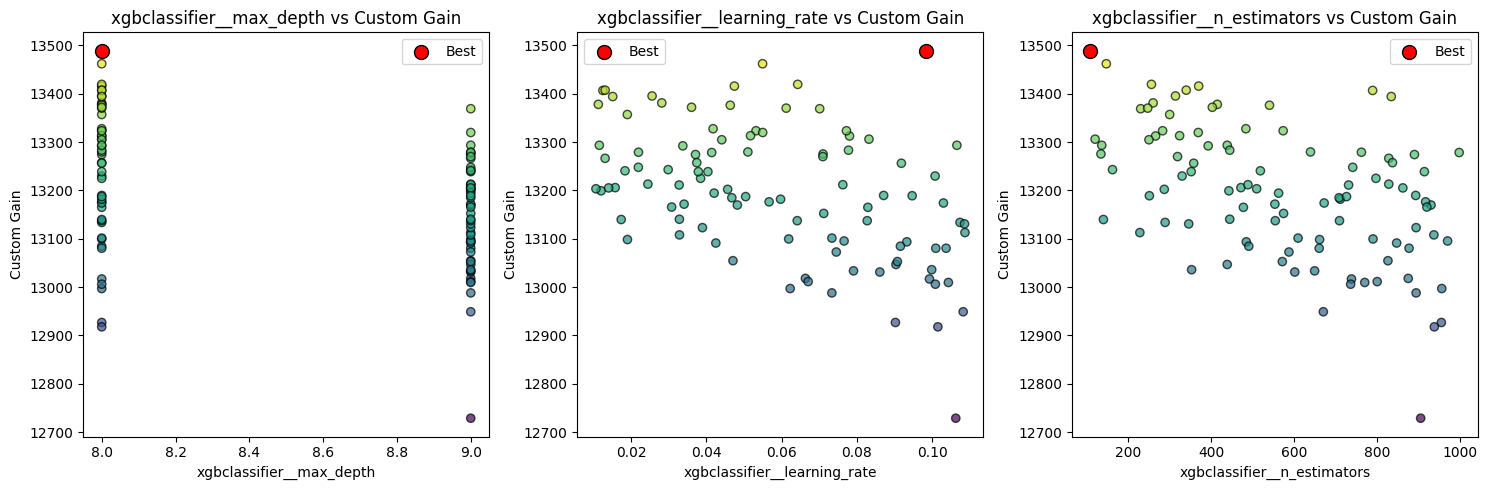

In [ ]:
# plotting parameters
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume the RandomizedSearchCV has already been fitted with the following:
# random_search.fit(X_train, y_train_classifier)

# Extract hyperparameters and custom gain scores from the RandomizedSearchCV results
results = random_search.cv_results_

# Extracting the hyperparameters and the corresponding mean test scores (custom gain scores)
hyperparameters = results['params']
mean_test_scores = results['mean_test_score']

# Convert the hyperparameters into a DataFrame for easy visualization
params_df = pd.DataFrame(hyperparameters)

# Add the mean test scores (custom gain) to the DataFrame
params_df['custom_gain'] = mean_test_scores

# Find the index of the best performing result
best_idx = params_df['custom_gain'].idxmax()
best_params = params_df.iloc[best_idx]
best_custom_gain = best_params['custom_gain']

# Now we can plot the hyperparameters against the custom gain scores.
# Here I will create a scatter plot for each hyperparameter individually.

fig, axes = plt.subplots(1, len(param_grid), figsize=(15, 5))  # One plot for each hyperparameter

# Iterate over each parameter and plot
for i, (param, ax) in enumerate(zip(param_grid.keys(), axes)):
    # Extract the specific hyperparameter and its custom gain values
    ax.scatter(params_df[param], params_df['custom_gain'], c=params_df['custom_gain'], cmap='viridis', edgecolors='k', alpha=0.7)

    # Highlight the best performing point with a red marker
    ax.scatter(best_params[param], best_custom_gain, color='red', s=100, label='Best', edgecolors='black')

    ax.set_xlabel(param)
    ax.set_ylabel('Custom Gain')
    ax.set_title(f'{param} vs Custom Gain')
    ax.legend()

plt.tight_layout()
plt.show()

This visualization explores the relationship between the hyperparameters and the custom gain scores from the RandomizedSearchCV process. Each scatter plot represents a specific hyperparameter and its impact on the model's custom gain. The best-performing combination, highlighted in red, achieves the highest custom gain score, helping identify the optimal values for maximizing the model's performance. This analysis provides a clear understanding of how each hyperparameter contributes to the overall model performance

In [ ]:
xgb_clf = make_pipeline(preprocessing, XGBClassifier(
    objective='binary:logistic',
    random_state=42,  # You can calculate scale_pos_weight based on class distribution
    learning_rate= 0.09826363431893397,
    max_depth=8,
    n_estimators=108
)
)

xgb_clf.fit(X_train, y_train_classifier)
y_pred = xgb_clf.predict(X_test)
test_score = custom_gain(y_test_classifier, y_pred)
print(f"Tuned XGBClassifier Test Score (Custom Gain): {test_score:.4f}")

Tuned XGBClassifier Test Score (Custom Gain): 21059.0000


After tuning, the XGBClassifier achieved a test score of 21,059.0 (custom gain), compared to the pre-tuning score of 20,750.0. This improvement demonstrates the effectiveness of hyperparameter optimization in enhancing the model's ability to balance gains and costs more effectively

## **Voting**

In [ ]:
# soft voting
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

voting_classifier = make_pipeline(
    preprocessing,  # Add preprocessing pipeline first
    VotingClassifier(
    estimators=[
        ('Logistic Regression (Balanced)', LogisticRegression(
    random_state=42,
    max_iter=960,
    C=3.845401188473625,
    penalty='l2',
    tol=2.8343478986616378e-05,
    class_weight='balanced',
    solver='liblinear'
)),
        ('Catboost', CatBoostClassifier( # Equivalent to binary:logistic for CatBoost
    random_state=42,
    max_depth = 7,
    l2_leaf_reg= 7.314153737307647,
    verbose=0  # Suppress training output
))
    ],
    voting='soft'  # Change to 'soft' if you want probability-based voting
))


# Fit the model
voting_classifier.fit(X_train, y_train_classifier)

# Predict and score using the voting classifier
y_pred = voting_classifier.predict(X_test)

A soft voting ensemble model was created using a VotingClassifier that combines Logistic Regression (Balanced) and CatBoost Classifier. The ensemble utilizes probability-based voting (voting='soft'), allowing the classifiers to weigh their predictions based on confidence levels. The model is built within a pipeline that includes preprocessing and is fitted on the training data. This approach leverages the strengths of individual classifiers while improving overall prediction accuracy and robustness

In [ ]:
# Confusion matrix for our model

test_score = custom_gain(y_test_classifier, y_pred)
print(f"Voting Classifier Test Score (Custom Gain): {test_score:.4f}")

conf_matrix = confusion_matrix(y_test_classifier, y_pred)
tn_model, fp_model, fn_model, tp_model = conf_matrix.ravel()

# Print TP, FP, TN, FN for both models
print("\nModel Performance:")
print(f"True Positives (TP): {tp_model}")
print(f"False Positives (FP): {fp_model}")
print(f"True Negatives (TN): {tn_model}")
print(f"False Negatives (FN): {fn_model}")

Voting Classifier Test Score (Custom Gain): 25187.0000

Model Performance:
True Positives (TP): 1586
False Positives (FP): 1170
True Negatives (TN): 7587
False Negatives (FN): 3303


The model achieved a test score of 25,187.0 (custom gain), representing a **578.96%** improvement over the Null model's custom gain of 3,710.8. This indicates the model's effectiveness in balancing gains and costs. The performance metrics show 1,586 true positives (correctly predicted clicks) and 7,587 true negatives (correctly predicted non-clicks), alongside 1,170 false positives (incorrectly predicted clicks) and 3,303 false negatives (missed clicks). This highlights the model's strength in identifying non-clicks while leaving room for improvement in reducing false negatives.



**Optimizing Voting Ensembles for Maximum Custom Gain**

The comparison between hard and soft voting demonstrated that soft voting performed better overall. However, when the top three models were combined, the custom gain score (22,991.00) was worse than that of the best-performing individual model, Logistic Regression. Removing Logistic Regression further reduced the score, confirming its importance in the ensemble. Interestingly, eliminating CatBoost increased the score to 24,806, while removing XGBoost resulted in the highest score of 25,187. Based on these findings, the optimal ensemble for maximizing custom gain is a combination of Logistic Regression and CatBoost, with XGBoost excluded from the final implementation.

# **Regression Model**

In [ ]:
# Filter records where y_train > 0
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]

# Filter records where y_test > 0
X_test_reg = X_test[y_test > 0]
y_test_reg = y_test[y_test > 0]

Filtering the training and testing datasets to include only records where the target variable (y_train and y_test) is greater than 0. This step ensures that the regression model focuses exclusively on instances with non-zero target values, as these are the relevant cases for predicting the target variable

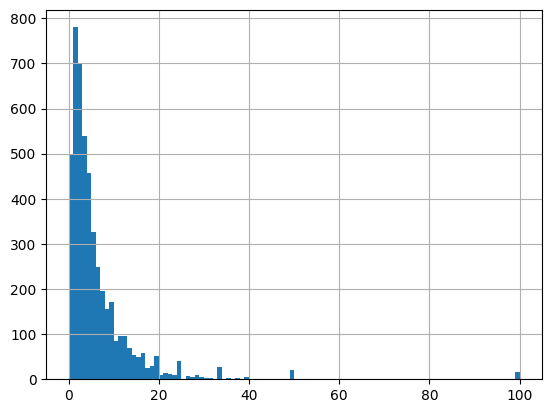

In [ ]:
y_test_reg.hist(bins = 100);

Visualizing the distribution of the filtered target variable (y_test_reg) using a histogram with 100 bins. This helps in understanding the range, skewness, and overall distribution of the target values in the regression test set

In [ ]:
y_train_log = np.log1p(y_train_reg)
y_test_log = np.log1p(y_test_reg)

The log1p transformation is applied to y_train_reg and y_test_reg to reduce skewness in the target variable, as it stabilizes variance and handles large ranges of values effectively. This transformation ensures better performance and stability for regression models that assume normally distributed target variables.

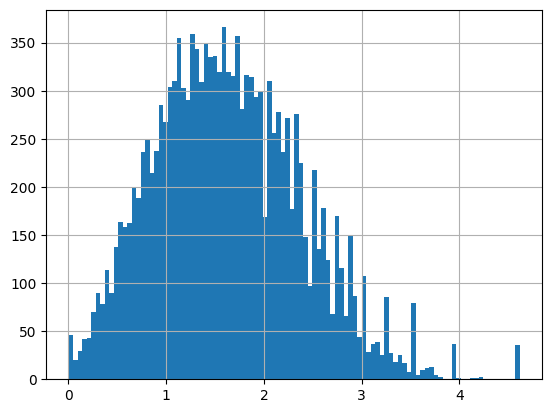

In [ ]:
y_train_log.hist(bins = 100);

A histogram of the log-transformed target variable (y_train_log) is plotted with 100 bins to visualize its distribution. This helps confirm whether the log1p transformation successfully reduced skewness and brought the target values closer to a normal distribution

**Evaluation Metric for Regression Models**

Root Mean Squared Error (RMSE) will be used as the evaluation metric to compare regression models. RMSE measures the average magnitude of errors between predicted and actual values, with a greater penalty for larger errors

## **Model Selection**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Define regressors
regressors = {
    'Null Model (Mean Prediction)': DummyRegressor(strategy='mean'),
    'Linear Regression': make_pipeline(preprocessing, LinearRegression()),
    'Ridge Regression': make_pipeline(preprocessing, Ridge(random_state=42)),

    'Random Forest Regressor': make_pipeline(preprocessing, RandomForestRegressor(random_state=42)),
    'SVR': make_pipeline(preprocessing, SVR()),

    'Decision Tree Regressor': make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42)),

    'XGBoost': make_pipeline(preprocessing, XGBRegressor(random_state=42)),

    'CatBoost': make_pipeline(preprocessing, CatBoostRegressor(random_state=42, verbose=0)),
}

# Perform cross-validation using negative RMSE as the scoring metric
results_reg = []

# Iterate over regressors
for name, reg in regressors.items():
    print(f"Evaluating: {name}")

    # Perform cross-validation using negative RMSE
    scores_neg_rmse = -cross_val_score(reg, X_train_reg, y_train_log, cv=5, scoring='neg_root_mean_squared_error')

    # Append the mean score and standard deviation for RMSE
    results_reg.append({
        'Model': name,
        'Mean Negative RMSE': round(scores_neg_rmse.mean(), 4),  # Now positive RMSE
        'Std Dev Negative RMSE': round(scores_neg_rmse.std(), 4)
    })

# Create a DataFrame from the results
results_df_reg = pd.DataFrame(results_reg)

# Set 'Model' as the index
results_df_reg.set_index('Model', inplace=True)

# Display the results
print("\nModel Performance Comparison (Root Mean Squared Error):")
print(results_df_reg)

Evaluating: Null Model (Mean Prediction)
Evaluating: Linear Regression
Evaluating: Ridge Regression
Evaluating: Random Forest Regressor
Evaluating: SVR
Evaluating: Decision Tree Regressor
Evaluating: XGBoost
Evaluating: CatBoost

Model Performance Comparison (Root Mean Squared Error):
                              Mean Negative RMSE  Std Dev Negative RMSE
Model                                                                  
Null Model (Mean Prediction)              0.7554                 0.0045
Linear Regression                         0.6988                 0.0068
Ridge Regression                          0.6987                 0.0068
Random Forest Regressor                   0.7386                 0.0092
SVR                                       0.6833                 0.0085
Decision Tree Regressor                   0.8061                 0.0096
XGBoost                                   0.6991                 0.0075
CatBoost                                  0.6842                 0

Most models outperform the null model (RMSE: 0.7554), with the best performers being SVR (0.6833) and CatBoost (0.6842). Linear and Ridge Regression also show improvements (0.6988 and 0.6987), while Random Forest (0.7386) and Decision Tree (0.8061) perform worse, indicating potential overfitting or limited generalization.

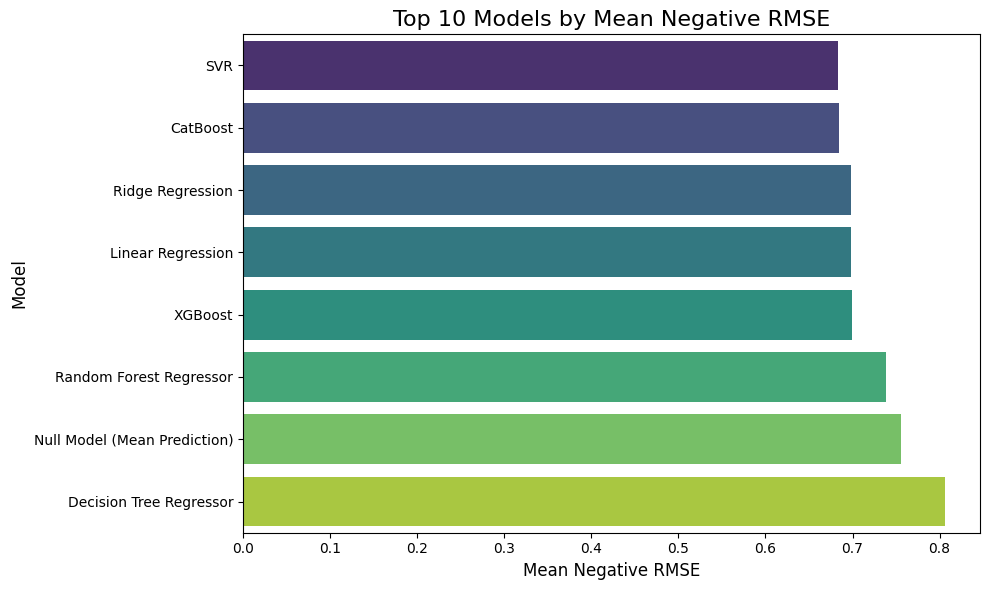

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'Mean Negative RMSE' in ascending order (lowest RMSE is better)
top_10_models_reg = results_df_reg.sort_values(by='Mean Negative RMSE', ascending=True).head(10)

# Plot the top 10 models using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_10_models_reg['Mean Negative RMSE'],
    y=top_10_models_reg.index,
    palette='viridis'
)

# Add labels and title
plt.title('Top 10 Models by Mean Negative RMSE', fontsize=16)
plt.xlabel('Mean Negative RMSE', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

Visualizing the results obtained for better interpretability using a bar plot

## **Fine-Tuning the Top Two Models**

There was a significant difference between the scores of SVR and Ridge Regression, leading to the selection of only the top two models. However, the scores of SVR and CatBoost were very close, highlighting their comparable performance

**CatBoost**

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

catboost_model = make_pipeline(
    preprocessing,
    CatBoostRegressor(random_state=42, verbose=0)
)

catboost_model.fit(X_train_reg, y_train_log)

y_pred_log = catboost_model.predict(X_test_reg)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

print(f"Untuned Catboost Regressor RMSE: {rmse:.4f}")

Untuned Catboost Regressor RMSE: 0.6997


In [ ]:
#catboost hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from scipy.stats import uniform

param_dist = {
    'catboostregressor__learning_rate': uniform(0.001, 0.1),
    'catboostregressor__depth': randint(5, 9),
}

pipeline = make_pipeline(
    preprocessing,
    CatBoostRegressor(random_state=42, verbose=0)
)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_reg, y_train_log)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'catboostregressor__depth': 6, 'catboostregressor__learning_rate': 0.016599452033620267}
Best Score: 0.679887891742445


The random search process for the CatBoost Regressor involved fitting 3 folds for each of 10 parameter combinations, totaling 30 fits. The best parameters identified were depth=6 and learning_rate=0.0166, achieving the lowest RMSE of 0.6799. This indicates the optimal configuration for minimizing prediction errors

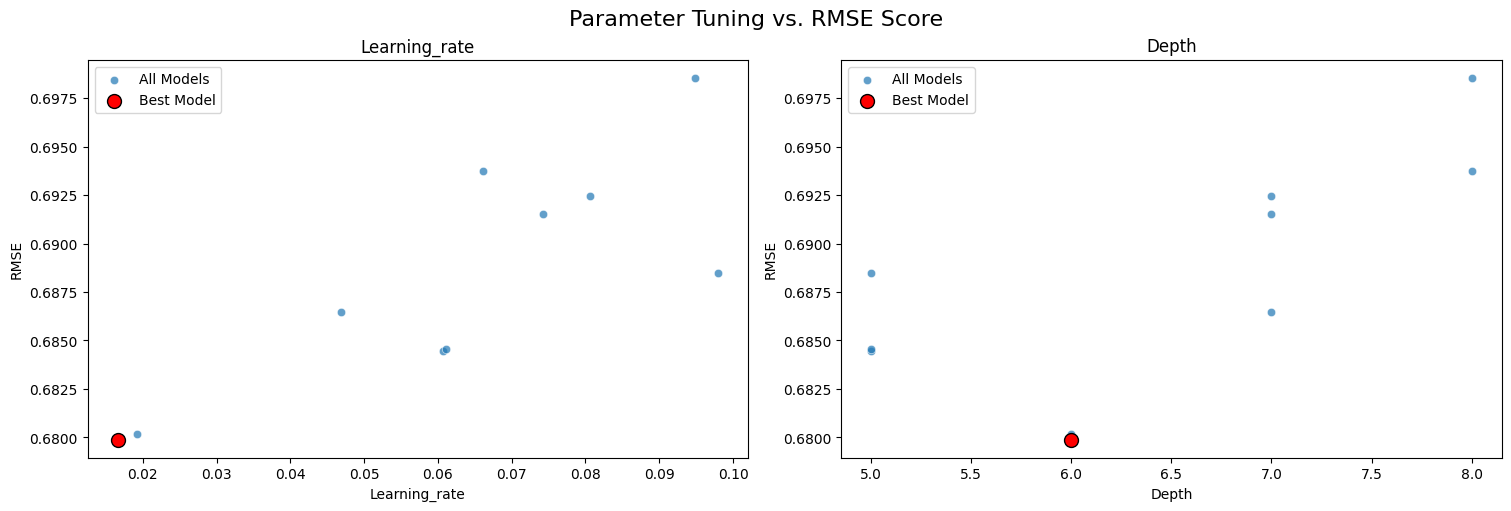

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract results from RandomizedSearchCV
cv_results = pd.DataFrame(random_search.cv_results_)

# Convert RMSE score (negative) to positive for clarity
cv_results['rmse'] = -cv_results['mean_test_score']

# Get the best performing model's parameters and score
best_params = random_search.best_params_
best_rmse = -random_search.best_score_

# Create scatter plots for each parameter
fig, axes = plt.subplots(1, len(param_dist), figsize=(15, 5), constrained_layout=True)
fig.suptitle("Parameter Tuning vs. RMSE Score", fontsize=16)

for ax, param in zip(axes, param_dist.keys()):
    # Scatter plot for the parameter
    sns.scatterplot(
        x=cv_results[f'param_{param}'],
        y=cv_results['rmse'],
        ax=ax,
        alpha=0.7,
        label='All Models'
    )

    # Highlight the best model
    best_value = best_params[param]
    ax.scatter(
        best_value,
        best_rmse,
        color='red',
        label='Best Model',
        edgecolor='black',
        s=100,
        zorder=5
    )

    # Customizing the plot
    ax.set_title(param.replace('catboostregressor__', '').capitalize())
    ax.set_xlabel(param.replace('catboostregressor__', '').capitalize())
    ax.set_ylabel('RMSE')
    ax.legend()

# Show plot
plt.show()

This visualization explores the relationship between each hyperparameter and the RMSE score for the CatBoost Regressor during the RandomizedSearchCV process. Scatter plots for each parameter show the distribution of RMSE scores across all tested models, with the best-performing model highlighted in red. This allows for easy identification of the parameter values (learning_rate and depth) that minimize RMSE, providing insights into how each hyperparameter impacts model performance

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

catboost_model = make_pipeline(
    preprocessing,
    CatBoostRegressor(random_state=42, verbose=0, depth= 7, learning_rate= 0.016599452033620267)
)

catboost_model.fit(X_train_reg, y_train_log)

y_pred_log = catboost_model.predict(X_test_reg)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"Tuned Catboost Regressor RMSE: {rmse:.4f}")

Tuned Catboost Regressor RMSE: 0.6942


After tuning, the CatBoost Regressor achieved an improved RMSE of 0.6942, compared to the pre-tuning RMSE of 0.6997

**SVR**

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

svr_pipeline = make_pipeline(
    preprocessing,
    SVR()
)

svr_pipeline.fit(X_train_reg, y_train_log)

y_pred_log = svr_pipeline.predict(X_test_reg)

rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

print(f"Untuned SVR RMSE: {rmse:.4f}")

Untuned SVR RMSE: 0.6981


In [ ]:
#hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.stats import uniform

# Define hyperparameter space for SVR
param_dist = {
    'svr__C': uniform(0.1, 1),       # Regularization parameter
    'svr__epsilon': uniform(0.1, 1) # Kernel coefficient
}

# Create a pipeline with preprocessing and SVR
pipeline = make_pipeline(
    preprocessing,  # Example preprocessing step
    SVR()
)

# RandomizedSearchCV for SVR
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',  # Use RMSE as the metric
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit RandomizedSearchCV
random_search.fit(X_train_reg, y_train_log)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'svr__C': 0.4042422429595377, 'svr__epsilon': 0.6247564316322378}
Best Score: 0.6816023341713238


The random search process for the SVR model involved fitting 3 folds for each of 10 parameter combinations, totaling 30 fits. The best parameters identified were C=0.4042 and epsilon=0.6248, achieving the lowest RMSE score of 0.6816. This indicates the optimal hyperparameter configuration for minimizing prediction errors

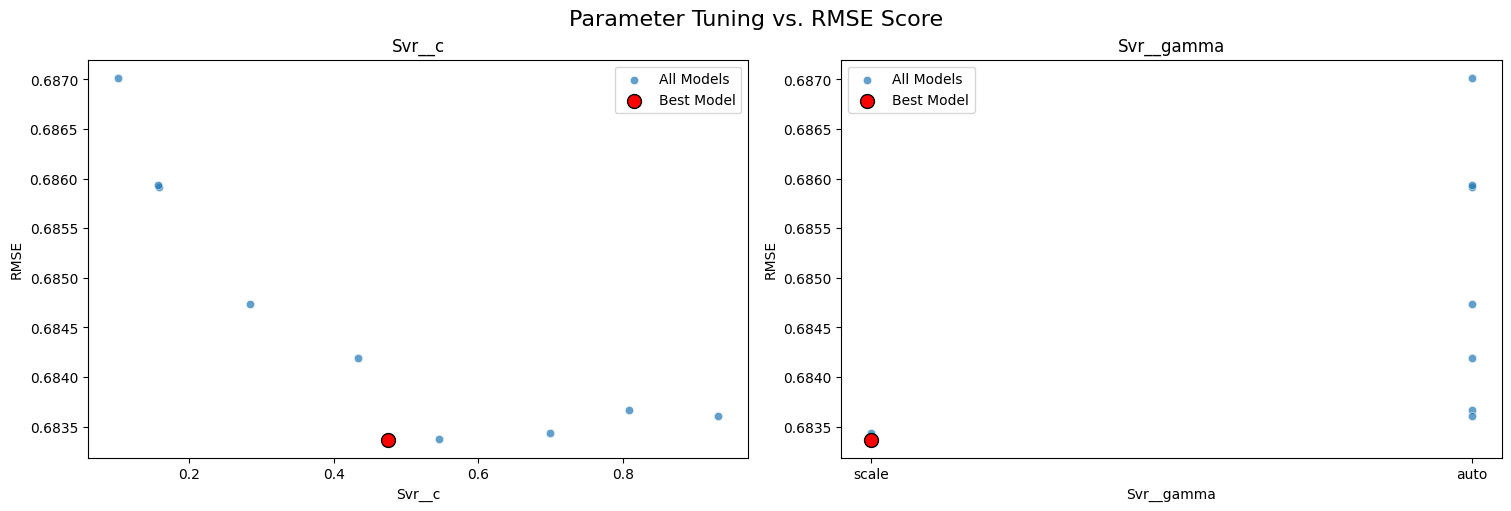

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract results from RandomizedSearchCV
cv_results = pd.DataFrame(random_search.cv_results_)

# Convert RMSE score (negative) to positive for clarity
cv_results['rmse'] = -cv_results['mean_test_score']

# Get the best performing model's parameters and score
best_params = random_search.best_params_
best_rmse = -random_search.best_score_

# Create scatter plots for each parameter
fig, axes = plt.subplots(1, len(param_dist), figsize=(15, 5), constrained_layout=True)
fig.suptitle("Parameter Tuning vs. RMSE Score", fontsize=16)

for ax, param in zip(axes, param_dist.keys()):
    # Scatter plot for the parameter
    sns.scatterplot(
        x=cv_results[f'param_{param}'],
        y=cv_results['rmse'],
        ax=ax,
        alpha=0.7,
        label='All Models'
    )

    # Highlight the best model
    best_value = best_params[param]
    ax.scatter(
        best_value,
        best_rmse,
        color='red',
        label='Best Model',
        edgecolor='black',
        s=100,
        zorder=5
    )

    # Customizing the plot
    ax.set_title(param.replace('catboostregressor__', '').capitalize())
    ax.set_xlabel(param.replace('catboostregressor__', '').capitalize())
    ax.set_ylabel('RMSE')
    ax.legend()

# Show plot
plt.show()

This visualization plots the relationship between hyperparameters and RMSE scores from the RandomizedSearchCV process. Each scatter plot highlights the tested parameter values, with the best-performing configuration (lowest RMSE) marked in red for easy identification

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

svr_model = make_pipeline(
    preprocessing,
    SVR(C = 0.4042422429595377, epsilon= 0.6247564316322378, gamma = 'scale')
)

svr_model.fit(X_train_reg, y_train_log)

y_pred_log = svr_model.predict(X_test_reg)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"Tuned SVR RMSE: {rmse:.4f}")

Tuned SVR RMSE: 0.6960


After tuning, the SVR model achieved a slightly improved RMSE of 0.6960 compared to the pre-tuning RMSE of 0.6981

## **Voting**

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
from sklearn.svm import SVR

voting_regressor = make_pipeline(
    preprocessing,
    VotingRegressor(
    estimators=[
        ('CatBoost Regressor',CatBoostRegressor(random_state=42, verbose=0, depth= 7, learning_rate= 0.016599452033620267)),
        ('SVR', SVR(C = 0.4042422429595377, epsilon= 0.6247564316322378, gamma = 'scale')),
    ] # Change to 'soft' if you want probability-based voting
))


# Fit the model
voting_regressor.fit(X_train_reg, y_train_log)

# Predict and score using the voting classifier
y_pred_log = voting_regressor.predict(X_test_reg)

# Custom gain function for scoring
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
print(f"Voting Regressor Test RMSE score: {rmse:.4f}")

Voting Regressor Test RMSE score: 0.6941


Using a VotingRegressor ensemble to combine the predictions of two regressors, CatBoost Regressor and SVR, achieved an RMSE of 0.6941, representing an **8.11%** improvement over the Null model's RMSE of 0.7554. This demonstrates the ensemble's accuracy and effectiveness in minimizing prediction errors.

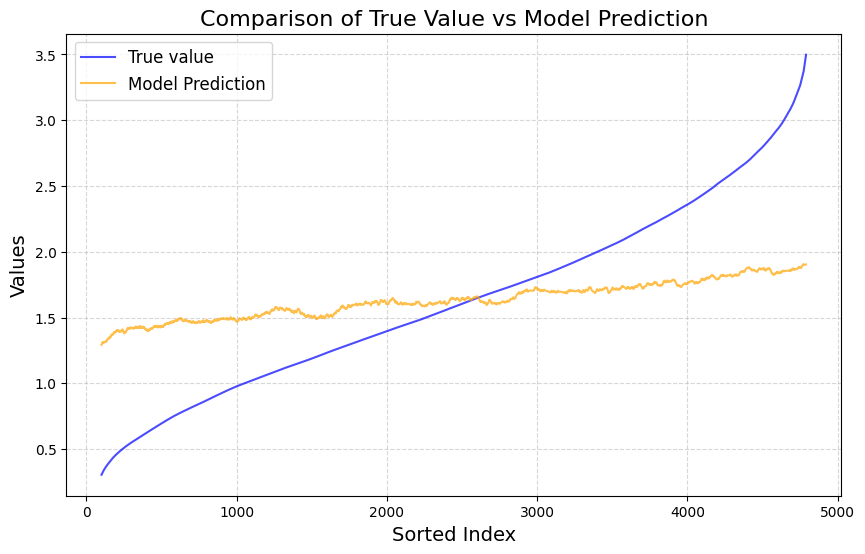

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Example arrays (replace with your actual data)

array1 = y_test_log
array2 = y_pred_log
x = np.arange(0, len(array1))

# Create dataframe
df = pd.DataFrame({'x': x, 'array1': array1, 'array2': array2})

# Sort the dataframe by 'array1' for better visual alignment
df = df.sort_values(by=['array1', 'array2']).reset_index(drop=True)

# Apply rolling mean smoothing
df['array1_smoothed'] = df['array1'].rolling(window=200, center=True).mean()
df['array2_smoothed'] = df['array2'].rolling(window=200, center=True).mean()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['array1_smoothed'], label='True value', color='blue', alpha=0.7)
plt.plot(df.index, df['array2_smoothed'], label='Model Prediction', color='orange', alpha=0.7)

# Add labels, title, and legend
plt.title('Comparison of True Value vs Model Prediction', fontsize=16)
plt.xlabel('Sorted Index', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle='--', alpha=0.5)

# Show the plot
plt.show()

This visualization compares the true values and the predicted values of the regression model using a smoothed line plot. The plot highlights how well the model predictions align with the actual values, providing insights into the model's performance across the dataset

**Enhancing Prediction Accuracy with VotingRegressor Ensemble**

Taking the average of predictions through the VotingRegressor ensemble improves the RMSE compared to individual models. By combining the strengths of CatBoost Regressor and SVR, the ensemble reduces prediction errors and offsets the weaknesses of any single model. This averaging approach leverages complementary patterns captured by the models, leading to a more accurate and robust overall prediction.

# **Combined Model Prediction**

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred_classifier = voting_classifier.predict(X_test)
conf_matrix = confusion_matrix(y_test_classifier, y_pred_classifier)
custom_gain_model = custom_gain(y_test_classifier, y_pred_classifier)

# Create a DummyClassifier for the null model
null_model = DummyClassifier(strategy="most_frequent")
null_model.fit(X_train, y_train_classifier)
y_pred_null = null_model.predict(X_test)
conf_matrix_null = confusion_matrix(y_test_classifier, y_pred_null)
custom_gain_null = custom_gain(y_test_classifier, y_pred_null)

This code evaluates the combined model (voting_classifier) and compares it to a baseline null model (DummyClassifier). The voting_classifier predicts the test labels (y_pred_classifier), and its performance is measured using a confusion matrix and a custom gain score. The null model predicts using the most frequent class, and its predictions are similarly evaluated. This comparison highlights the effectiveness of the combined model relative to a simple baseline

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for your model
conf_matrix = confusion_matrix(y_test_classifier, y_pred_classifier)
tn_model, fp_model, fn_model, tp_model = conf_matrix.ravel()

# Confusion matrix for the null model
conf_matrix_null = confusion_matrix(y_test_classifier, y_pred_null)
tn_null, fp_null, fn_null, tp_null = conf_matrix_null.ravel()

# Print the confusion matrices
print("Confusion Matrix (Model):")
print(conf_matrix)
print("Confusion Matrix (Null Model):")
print(conf_matrix_null)

# Print the custom gain scores
print(f"Custom Gain (Model): {custom_gain_model}")
print(f"Custom Gain (Null Model): {custom_gain_null}")

# Print TP, FP, TN, FN for both models
print("\nModel Performance:")
print(f"True Positives (TP): {tp_model}")
print(f"False Positives (FP): {fp_model}")
print(f"True Negatives (TN): {tn_model}")
print(f"False Negatives (FN): {fn_model}")

print("\nNull Model Performance:")
print(f"True Positives (TP): {tp_null}")
print(f"False Positives (FP): {fp_null}")
print(f"True Negatives (TN): {tn_null}")
print(f"False Negatives (FN): {fn_null}")


Confusion Matrix (Model):
[[7587 1170]
 [3303 1586]]
Confusion Matrix (Null Model):
[[8757    0]
 [4889    0]]
Custom Gain (Model): 25187
Custom Gain (Null Model): 4673

Model Performance:
True Positives (TP): 1586
False Positives (FP): 1170
True Negatives (TN): 7587
False Negatives (FN): 3303

Null Model Performance:
True Positives (TP): 0
False Positives (FP): 0
True Negatives (TN): 8757
False Negatives (FN): 4889


The combined model outperforms the null model significantly, achieving a custom gain score of 25,187 compared to the null model's 4,673.
The combined model identifies 1586 true positives (TP) and 7,587 true negatives (TN), while the null model fails to predict any true positives, with all positive cases classified as false negatives. This demonstrates the combined model's superior ability to correctly identify both clicked and non-clicked instances, effectively balancing gains and costs

In [ ]:
#replace second_model
X_test_pred = X_test[y_pred_classifier == 1]
y_pred_regression = voting_regressor.predict(X_test_pred)
final_predictions = np.zeros_like(y_test, dtype=float)  # Initialize with zeros, same shape as y_test
final_predictions[y_pred_classifier == 1] = y_pred_regression

Integrating the combined classification and regression models to make final predictions. Instances where the classifier predicts a positive outcome are identified, and the regression model is applied to predict target values for those instances. The final predictions array is initialized with zeros and updated with the regression predictions for the positively classified instances, maintaining consistency in the prediction format across all test data

In [ ]:
y_test_final = np.zeros_like(y_test, dtype=float)# Initialize with zeros, same shape as y_test
y_test_final[y_test >0] = y_test_log

Preparing the final test target variable for evaluation by initializing an array of zeros with the same shape as y_test and update it with the log-transformed target values only for instances where the original y_test is greater than 0. This ensures alignment between the predicted values and the corresponding true target values for regression evaluation

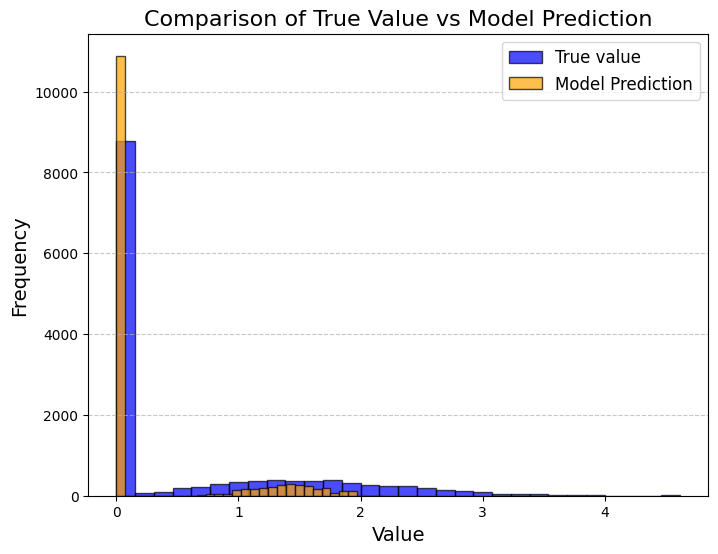

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(y_test_final, bins=30, alpha=0.7, color='blue', label='True value', edgecolor='black')
plt.hist(final_predictions, bins=30, alpha=0.7, color='orange', label='Model Prediction', edgecolor='black')

# Add labels, title, and legend
plt.title('Comparison of True Value vs Model Prediction', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

This histogram compares the distribution of true target values and the model's predictions. The blue bars represent the true values, while the orange bars represent the model's predicted values. The overlay allows for a visual assessment of how closely the model's predictions align with the actual values, particularly in the lower range of the target variable. The plot demonstrates that while the model captures the overall distribution, discrepancies remain in certain value ranges, highlighting areas for potential improvement

# **Challenges & Key Takeaways**

**Extensive Data Preprocessing:** Our dataset was large, containing almost 140,000 articles. Extracting and aggregating impressions and clicks for each article required extensive preprocessing, which we did through the use of parallel processing.

**Skewed Dataset:** The dataset was highly imbalanced, with a large number of articles having zero clicks. To address this, a two-step approach was used:

- A classification model to predict whether an article would receive clicks.
- A regression model built exclusively on the subset of articles that had been clicked.

**Google Trends Integration:** Implementing Google Trends data turned out to be computationally expensive and impractical within the scope of this project. Ultimately, the feature had to be dropped.

**Managing Narrowly Distributed Non-Zero Click Percentages
:** The click percentage values were tightly distributed, ranging between 0.01 and 1. Initially,
we tried applying a logarithmic transformation, but we faced issues. Some values became negative, with 0 falling in between, complicating model predictions. To resolve this, we applied log1p transformation, which avoided negatives and improved model performance. The narrow spread also caused the null model (predicting the mean) to outperform some of the top models. Taking log and increasing the spread, helped address this issue.

**Slow Performance of Certain Models:** Some models, like Support Vector Classifier (SVC), were extremely slow and computationally intensive. Additionally, SVC does not provide probability estimates, limiting its applicability in soft voting. As a result, we had to drop these models.

**Stacking Model Challenges:** Stacking failed to improve model performance, delivering worse results than individual models and other ensemble methods, so we decided not to use it.

**Classifier Voting Limitations:** When using an ensemble of classifiers for voting, the combined model's performance gain was lower than that of individual models which is why we dropped XGBoost. We learned that even the top-performing models may not always be the best combination for voting.

# **Conclusion & Future Steps**

In conclusion, the regression models utilized in this analysis were relatively weak learners, highlighting the need for further refinement. Future steps include exploring ensemble methods like boosting to improve performance and integrating extracted search terms with their trend velocity and impact to gain deeper insights, drawing parallels to search engine optimization techniques. This study’s future scope also extends beyond news articles, offering potential applications for predicting engagement across various content types, such as whether an advertisement gets clicked or a YouTube video gains traction. In the entertainment and publication industry where capturing attention is a valuable asset, utilizing data-driven techniques and advanced analytics to analyze and optimize engagement patterns can enhance predictive accuracy and provide better recommendations based on evolving trends.